In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


In [14]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from source.torch_acc import SLQDataset

from commands.experiment_7 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/experiment_7/"

from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_7_*/sl_merged_*.csv")

In [5]:
# # copy files
# base_path = "outputs/metadata/experiment_7/"
# paths = "outputs/metadata/experiment_7_1_*/slq*"
# for path in glob(paths):
#     newpath = "_".join(path.split("/")[-2:])
#     newpath = os.path.join(base_path, newpath)
#     # copy file from path to newpath
#     os.system(f"cp {path} {newpath}")

In [73]:
paths = os.path.join(save_metadata_dir, "*_0_slq_merged_*.csv")
paths = glob(paths)
print(paths)
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)


def minmax_normalize(x: np.ndarray, q=0.99):
    x[x > np.quantile(x, q=q)] = np.quantile(x, q=q)
    return (x - x.min()) / (x.max() - x.min())

['outputs/metadata/experiment_7/experiment_7_0_slq_merged_50.csv', 'outputs/metadata/experiment_7/experiment_7_0_slq_merged_70.csv', 'outputs/metadata/experiment_7/experiment_7_0_slq_merged_10.csv', 'outputs/metadata/experiment_7/experiment_7_1_0_slq_merged_10.csv', 'outputs/metadata/experiment_7/experiment_7_1_0_slq_merged_30.csv', 'outputs/metadata/experiment_7/experiment_7_1_0_slq_merged_70.csv', 'outputs/metadata/experiment_7/experiment_7_1_0_slq_merged_50.csv', 'outputs/metadata/experiment_7/experiment_7_0_slq_merged_30.csv', 'outputs/metadata/experiment_7/experiment_7_1_0_slq_merged_90.csv']


In [55]:
merged_data.shape

(33000, 7)

In [46]:
merged_data.columns

Index(['image_index', 'data_path', 'image_path', 'label', 'alpha_mask_value',
       'preds', 'q'],
      dtype='object')

In [47]:
merged_data.q.unique()

array([50, 70, 10, 30, 90])

In [56]:
na_ids = merged_data.alpha_mask_value.isna()
merged_data[na_ids].shape

(4000, 7)

In [74]:
merged_data.alpha_mask_value.fillna("SL", inplace=True)
merged_data.alpha_mask_value.unique()

array(['SL', 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 'IG'], dtype=object)

In [75]:
merged_data_acc = merged_data.groupby(["alpha_mask_value", "q"])["preds"].mean()
merged_data_acc.name = "Accuracy"
merged_data_acc = merged_data_acc.reset_index()

In [77]:
merged_data_acc.groupby("alpha_mask_value")["Accuracy"].mean()

alpha_mask_value
0.0    0.27900
0.1    0.27375
0.2    0.31250
0.3    0.33125
0.4    0.33000
0.5    0.32100
IG     0.19140
SL     0.31200
Name: Accuracy, dtype: float64

In [59]:
good_alphas = merged_data_acc["alpha_mask_value"].apply(
    lambda x: x in ["IG","SL", 0.0, 0.1, 0.2]
)
merged_data_acc = merged_data_acc[good_alphas]

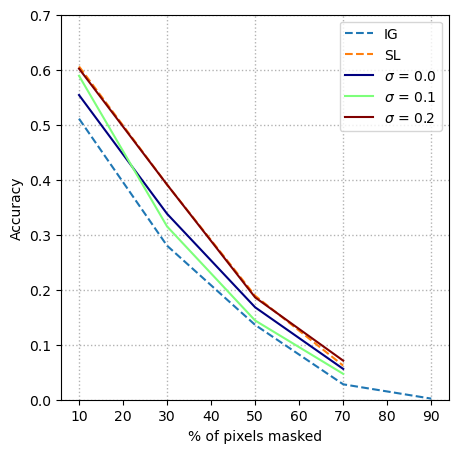

In [72]:
plt.figure(figsize=(5, 5))
# draw vertical lines at ticks
for q in merged_data_acc.q.unique():
    plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
# draw horizontal lines at ticks
plt.ylim(0, 0.7)
ticks = plt.yticks()[0]
for acc in ticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )


# find unique labels that are of type str
str_labels = merged_data_acc.alpha_mask_value.unique()
str_labels_ids = list(map(lambda x:isinstance(x,str),str_labels))
str_labels = str_labels[str_labels_ids]
# find unique labels that are of type float
float_labels = merged_data_acc.alpha_mask_value.unique()
float_labels_ids = list(map(lambda x:isinstance(x,float),float_labels))
float_labels = float_labels[float_labels_ids]

# color map for float labels
cmap = plt.get_cmap("jet")
color_dict = cmap(np.linspace(0, 1, len(float_labels)))

# plot str labels
for i, alpha in enumerate(str_labels):
    merged_data_acc_alpha = merged_data_acc[
        merged_data_acc.alpha_mask_value == alpha
    ]
    plt.plot(
        merged_data_acc_alpha.q,
        merged_data_acc_alpha.Accuracy,
        label=alpha,
        linestyle="--",
    )

for i, alpha in enumerate(float_labels):
    merged_data_acc_alpha = merged_data_acc[
        merged_data_acc.alpha_mask_value == alpha
    ]
    plt.plot(
        merged_data_acc_alpha.q,
        merged_data_acc_alpha.Accuracy,
        label=r"$\sigma$ = " + str(alpha),
        color=color_dict[i],
    )

# location top right
plt.legend(loc="upper right")
plt.xlabel("% of pixels masked")
plt.ylabel("Accuracy")
plt.savefig("outputs/figures/accuracy_vs_q.pdf", bbox_inches="tight")